In [11]:
from torch import nn
from torch import optim
import torch
import torch.utils.data as tdata
import pytorch_lightning as pl
import numpy as np
import os
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [28]:
from torch.utils.data import DataLoader

In [12]:
# plot by generations
from src.solver import Solver0D
from src.file_io import read_json
from collections import defaultdict

ModuleNotFoundError: No module named 'src.solver'

In [13]:
%matplotlib inline

# Functions 

In [14]:
def plot_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(2, 2, figsize = (16, 16))
    fig.tight_layout(pad = 3,rect = (.02,.02,1, .98))
    ax = ax.flatten()
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
        
        ax[2].clear()
        ax[3].clear()
        ax[2].set_title('Pressures (mmHg)')
        ax[2].set_xlabel('True Pressure')
        ax[2].set_ylabel('Predicted Pressure (mmHg)')
        ax[3].set_title('Flows (ml/s)')
        ax[3].set_xlabel('True Flow')
        ax[3].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[2].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        t = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[2].plot(t, t, color = 'r')
        ax[3].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        t = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[3].plot(t, t, color = 'r')
        
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_residuals_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_yhat_animation(predict_input, predict_output, save):
    
    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Pressures (mmHg)')
        ax[0].set_xlabel('True Pressure')
        ax[0].set_ylabel('Predicted Pressure (mmHg)')
        ax[1].set_title('Flows (ml/s)')
        ax[1].set_xlabel('True Flow')
        ax[1].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[0].plot(x, x, color = 'r')
        ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[1].plot(x, x, color = 'r')
        fig.suptitle(f'Vessel {vessel}')
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)

In [23]:
def d2m(val):
    return val / 1333.22

def RAE(y, yhat):
    ''' Relative absolute error'''
    rae = abs(y - yhat).sum() / abs(y - y.mean()).sum()
    return rae

def MaxRE(y, yhat):
    res = (abs(y - yhat) / y)
    max_re = res.max()
    return max_re

def AvgRE(y, yhat):
    res = (abs(y - yhat) / y)
    avg_re = res.mean()
    return avg_re

def get_y(predict_input, predict_output):
    ''' removes cases where predict_input < 1.0 anywhere'''
    input_filter = (predict_input < 1.0).any(dim = 1) == False
    y = predict_output[:, 0]
    yhat = predict_output[:, 1] # yhat
    return predict_input, y, yhat
    #return predict_input[input_filter], y[input_filter], yhat[input_filter]

def model_metrics(predict_input, predict_output):
    # remove cases where predict_input < 1.0
    x, y, yhat = get_y(predict_input, predict_output)
    
    p_rae = []
    q_rae = []
    max_re = []
    mean_re = []
    for i in range(len(y[0])):
        
        if i % 2 == 0:
            p_rae.append(RAE(y[:, i], yhat[:, i]))
        else:
            q_rae.append(RAE(y[:, i], yhat[:, i]))
        max_re.append(MaxRE(y[:, i], yhat[:, i]))
        mean_re.append(AvgRE(y[:, i], yhat[:, i]))
    for p in p_rae:
        print(f"{round(p.item() * 100, 2)}%", end = ' | ')
    print()
    print('Average Pressure RAE:', f"{round(np.array(p_rae).mean() * 100, 2)}%")
    for q in q_rae:
        print(f"{round(q.item() * 100, 2)}%", end = ' | ')
    print()
    print('Average Flow RAE:', f"{round(np.array(q_rae).mean() * 100, 2)}%")
    print("Average Total RAE:", f"{round(np.array(p_rae + q_rae).mean() * 100, 2)}%")
    print("Max Relative Error:", f"{round(np.array(max_re).max() * 100, 3)}%")
    print("Avg Relative Error:", f"{round(np.array(mean_re).mean() * 100, 3)}%")
    

def plot_losses(df, ylim = .2):
    ''' loss plot '''
    fig, ax = plt.subplots(1, 1)
    ax.plot(df['step'], df['train_loss'], alpha = .9, label = 'train_loss')    
    ax.plot(df['step'], df['val_loss'], color ='r', alpha = .5, marker = '^', label = 'val_loss')
    ax.plot(df['step'], df['test_loss'], color ='k', alpha = 1, marker = 'o', label = 'test_loss')
    ax.legend()
    ax.set_ylim(0, ylim)
    ax.set_xlabel('Steps')
    ax.set_ylabel('MSE Loss')
    ax.set_title('Training Logs')
    
    results(df)
    
def results(df):
    print('Final Train Loss:', df['train_loss'].dropna().iloc[-1])
    print('Final Val Loss:', df['val_loss'].dropna().iloc[-1])
    print('Final Test Loss:', df['test_loss'].dropna().iloc[-1])
    
def plot_residuals(predict_input, predict_output, vessel):

    P_vessel = vessel * 2
    Q_vessel = vessel * 2 + 1
    x, y, yhat = get_y(predict_input, predict_output)
    print(x.min())
    residuals = y - yhat
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax[0].set_title('Residual Pressures (mmHg)')
    ax[0].set_xlabel('radius change')
    ax[0].set_ylabel('residual (mmHg)')
    ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
    
    ax[1].set_title('Residual Flows (ml/s)')
    ax[1].set_xlabel('radius change')
    ax[1].set_ylabel('residual (ml/s)')
    ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
    
def plot_yhat(predict_input, predict_output, vessel):

    P_vessel = vessel * 2
    Q_vessel = vessel * 2 + 1
    _, y, yhat = get_y(predict_input, predict_output)
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax[0].set_title('Pressures (mmHg)')
    ax[0].set_xlabel('True Pressure')
    ax[0].set_ylabel('Predicted Pressure (mmHg)')
    ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
    x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
    ax[0].plot(x, x, color = 'r')
    
    ax[1].set_title('Flows (ml/s)')
    ax[1].set_xlabel('True Flow')
    ax[1].set_ylabel('Predicted Flow (ml/s)')
    ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
    x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
    ax[1].plot(x, x, color = 'r')


In [16]:
dataframe = lambda x: f"../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_1/training_results/run1/lightning_logs/version_{x}/metrics.csv"
predict_input = lambda x: torch.load(f"../data/archive/tmp/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_1/training_results/run1/lightning_logs/version_{x}/predict_input.pt")
predict_output = lambda x: torch.load(f"../data/archive/tmp/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_1/training_results/run1/lightning_logs/version_{x}/predict_output.pt")


In [29]:
torch.load(f"../data/archive/tmp/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_1/training_results/run1/lightning_logs/version_11/test_dataloader.pt")

AttributeError: Can't get attribute 'Dataset0D' on <module '__main__'>

# Version 0

-Previous best model

Final Train Loss: 0.0003426497278269
Final Val Loss: 0.0004821144684683
Final Test Loss: 0.0004666814929805


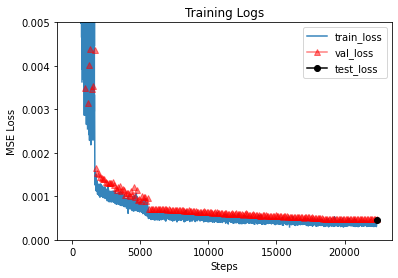

In [6]:
plot_losses(pd.read_csv(dataframe(0)), .005)

In [91]:
interact(plot_residuals, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [92]:
interact(plot_yhat, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

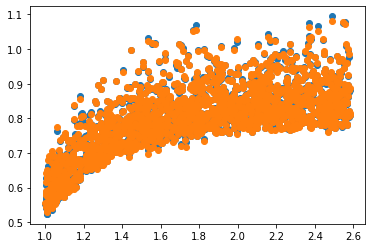

In [9]:
yall = predict_output(1)
y = yall[:, 0]
yhat = yall[:, 1]
x = predict_input(1)
vess = 13
plt.scatter(x[:, vess], y[:, vess * 2 + 1],)
plt.scatter(x[:, vess], yhat[:, vess *2 + 1])


In [10]:
model_metrics(predict_input(0),predict_output(0))

2.18% | 2.6% | 2.94% | 2.39% | 2.36% | 2.66% | 2.05% | 2.75% | 2.06% | 2.88% | 2.87% | 2.47% | 2.92% | 3.23% | 2.99% | 2.45% | 2.77% | 2.59% | 3.37% | 1.55% | 2.79% | 
Average Pressure RAE: 2.61%
1.89% | 2.6% | 2.84% | 2.14% | 2.37% | 2.68% | 2.08% | 2.72% | 2.07% | 2.86% | 2.87% | 2.47% | 2.92% | 3.26% | 2.99% | 2.45% | 2.74% | 2.59% | 3.37% | 1.56% | 2.78% | 
Average Flow RAE: 2.58%
Average Total RAE: 2.6%
Max Relative Error: 12.018%
Avg Relative Error: 0.26%


Residuals seem to follow a 1/x sin(x) wave?

# Version 1

Implement Difference if x < 1.2 in any location, but just regular model when x > 1.2 for all


- I will not pursue this further since it turns out there are 15k where any <1.2 and 900 where all > 1.2
- Also difference does not work well.

Final Train Loss: 0.0008530455525033
Final Val Loss: 0.0008075903751887
Final Test Loss: 0.0008806328987702


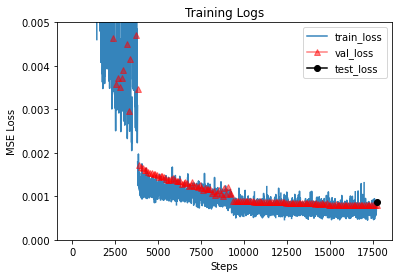

In [11]:
plot_losses(pd.read_csv(dataframe(1)), .005)

In [93]:
interact(plot_residuals, predict_input = fixed(predict_input(1)), predict_output = fixed(predict_output(1)), vessel = (0, len(predict_input(1)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [94]:
interact(plot_yhat, predict_input = fixed(predict_input(1)), predict_output = fixed(predict_output(1)), vessel = (0, len(predict_input(1)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

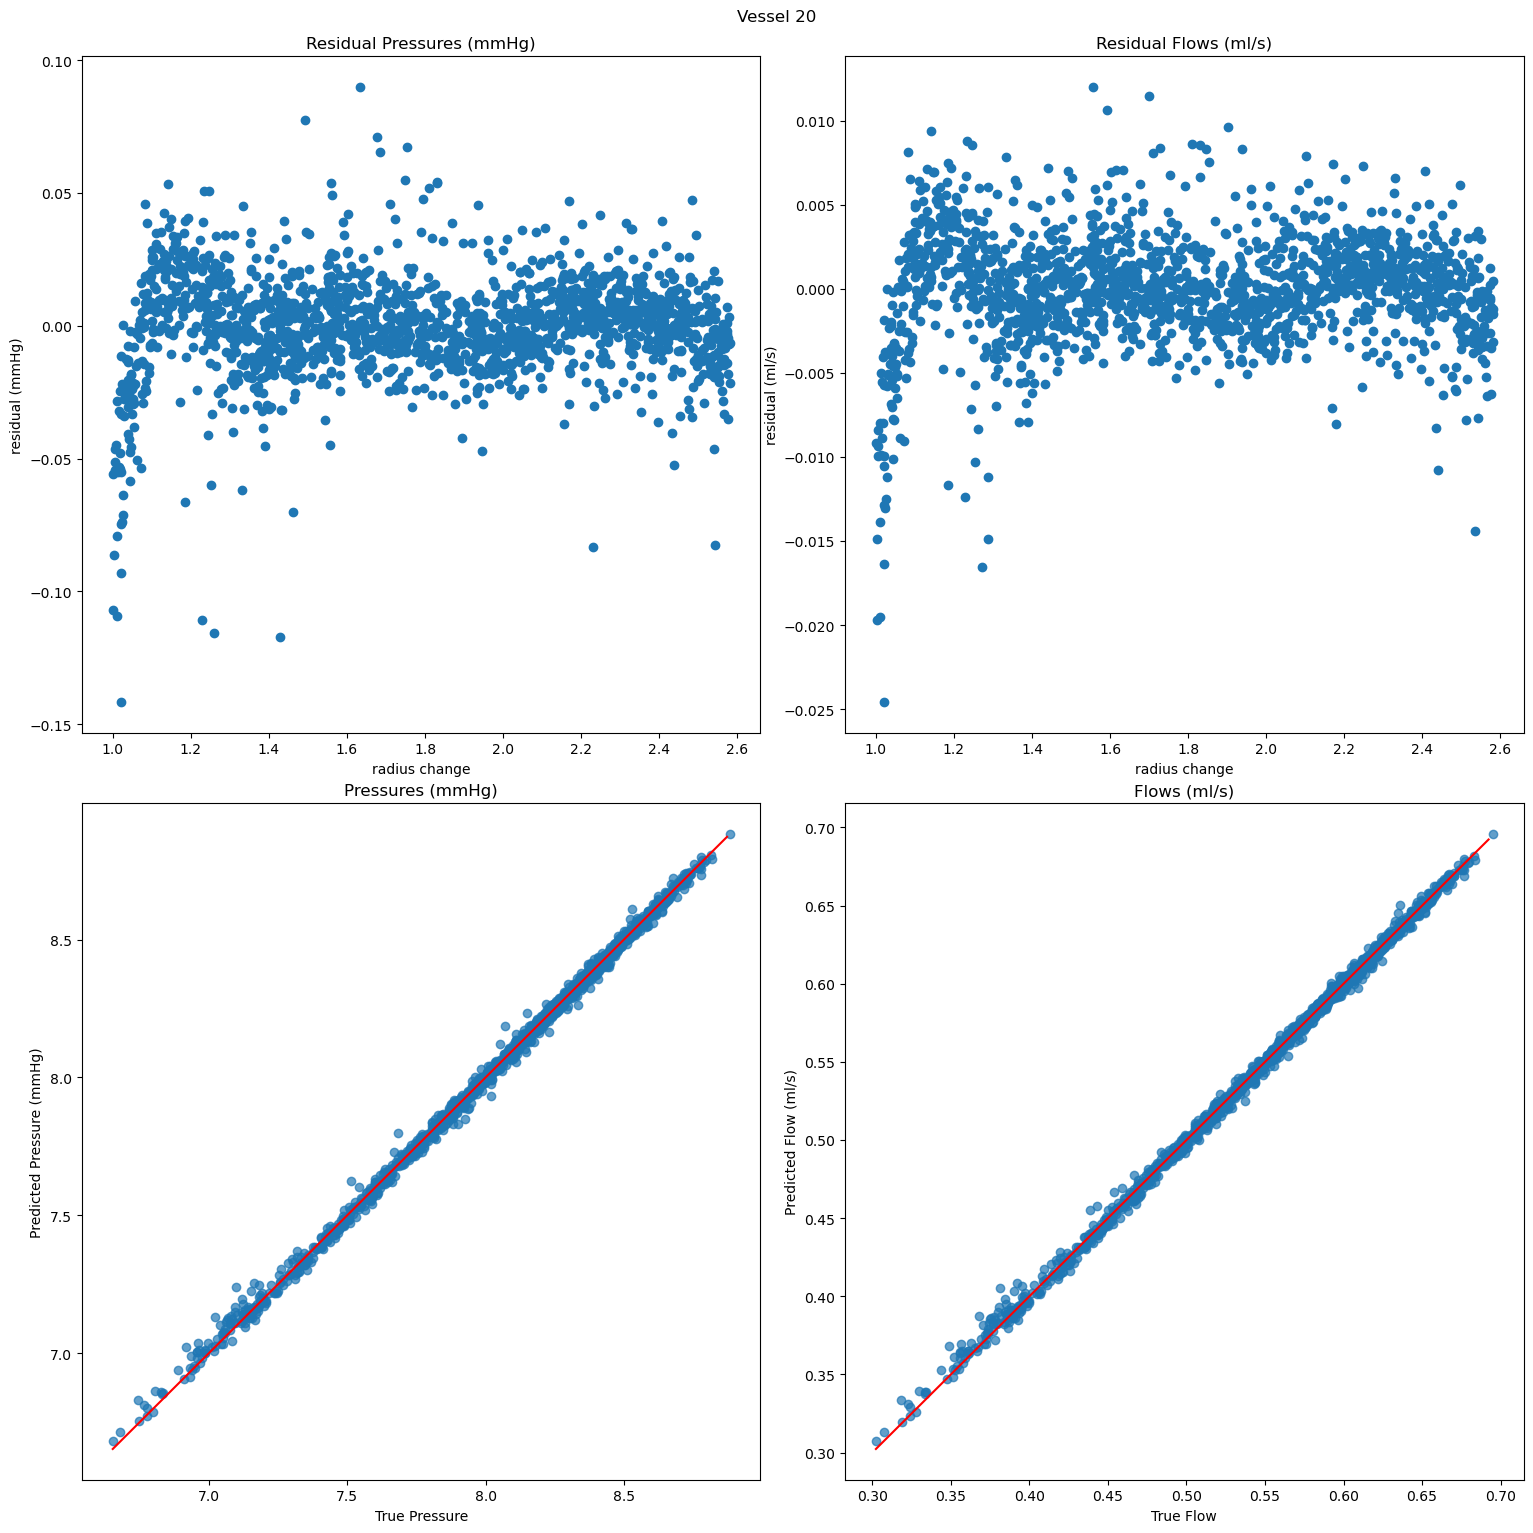

In [101]:
plot_animation(predict_input(1), predict_output(1), save = '../pptx/pptx_img/model.diff.gif')

In [14]:
model_metrics(predict_input(1), predict_output(1))

4.08% | 3.47% | 4.08% | 3.19% | 3.48% | 3.31% | 3.12% | 3.68% | 3.05% | 4.08% | 4.66% | 3.87% | 3.46% | 4.07% | 3.74% | 3.57% | 3.69% | 3.43% | 4.33% | 2.68% | 3.82% | 
Average Pressure RAE: 3.66%
2.89% | 3.52% | 3.64% | 2.96% | 3.52% | 3.21% | 3.18% | 3.61% | 3.1% | 3.78% | 4.12% | 3.73% | 3.42% | 3.84% | 3.99% | 3.44% | 3.53% | 3.46% | 4.52% | 2.84% | 3.76% | 
Average Flow RAE: 3.53%
Average Total RAE: 3.59%
Max Relative Error: 14.018%
Avg Relative Error: 0.355%


# Version 2

Split differences into its own model

Final Train Loss: 0.0007918167393654
Final Val Loss: 0.0009936561109498
Final Test Loss: 0.0009850378846749


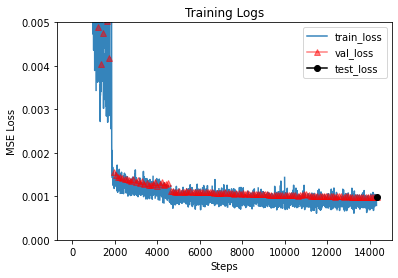

In [15]:
plot_losses(pd.read_csv(dataframe(2)), .005)


In [95]:
interact(plot_residuals, predict_input = fixed(predict_input(2)), predict_output = fixed(predict_output(2)), vessel = (0, len(predict_input(2)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [96]:
interact(plot_yhat, predict_input = fixed(predict_input(2)), predict_output = fixed(predict_output(2)), vessel = (0, len(predict_input(2)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [18]:
model_metrics(predict_input(2), predict_output(2))

4.96% | 3.77% | 5.36% | 3.63% | 3.03% | 3.69% | 2.83% | 4.48% | 3.24% | 3.66% | 3.82% | 4.27% | 3.23% | 3.87% | 4.64% | 4.01% | 3.45% | 4.04% | 5.18% | 2.78% | 4.44% | 
Average Pressure RAE: 3.92%
5.15% | 3.75% | 5.95% | 3.78% | 3.04% | 3.66% | 2.83% | 4.5% | 3.23% | 3.67% | 3.82% | 4.26% | 3.22% | 3.87% | 4.64% | 4.01% | 3.45% | 4.03% | 5.2% | 2.83% | 4.44% | 
Average Flow RAE: 3.97%
Average Total RAE: 3.94%
Max Relative Error: 9.995%
Avg Relative Error: 0.367%


# Version 3

Filter at 1.35

Final Train Loss: 0.0124154528602957
Final Val Loss: 0.0242933016270399
Final Test Loss: 0.024067660793662


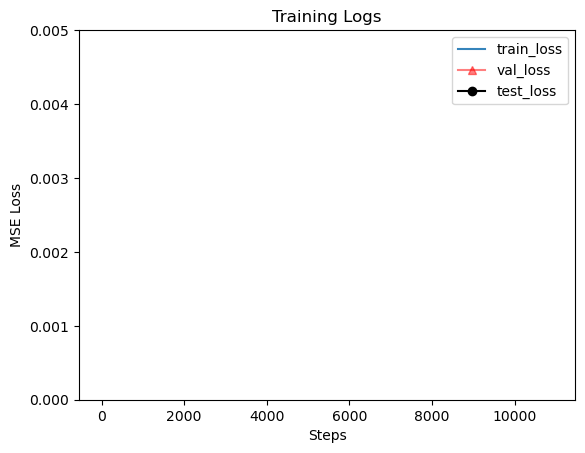

In [97]:
plot_losses(pd.read_csv(dataframe(3)), .005)


In [98]:
interact(plot_residuals, predict_input = fixed(predict_input(3)), predict_output = fixed(predict_output(3)), vessel = (0, len(predict_input(3)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [99]:
interact(plot_yhat, predict_input = fixed(predict_input(3)), predict_output = fixed(predict_output(3)), vessel = (0, len(predict_input(3)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

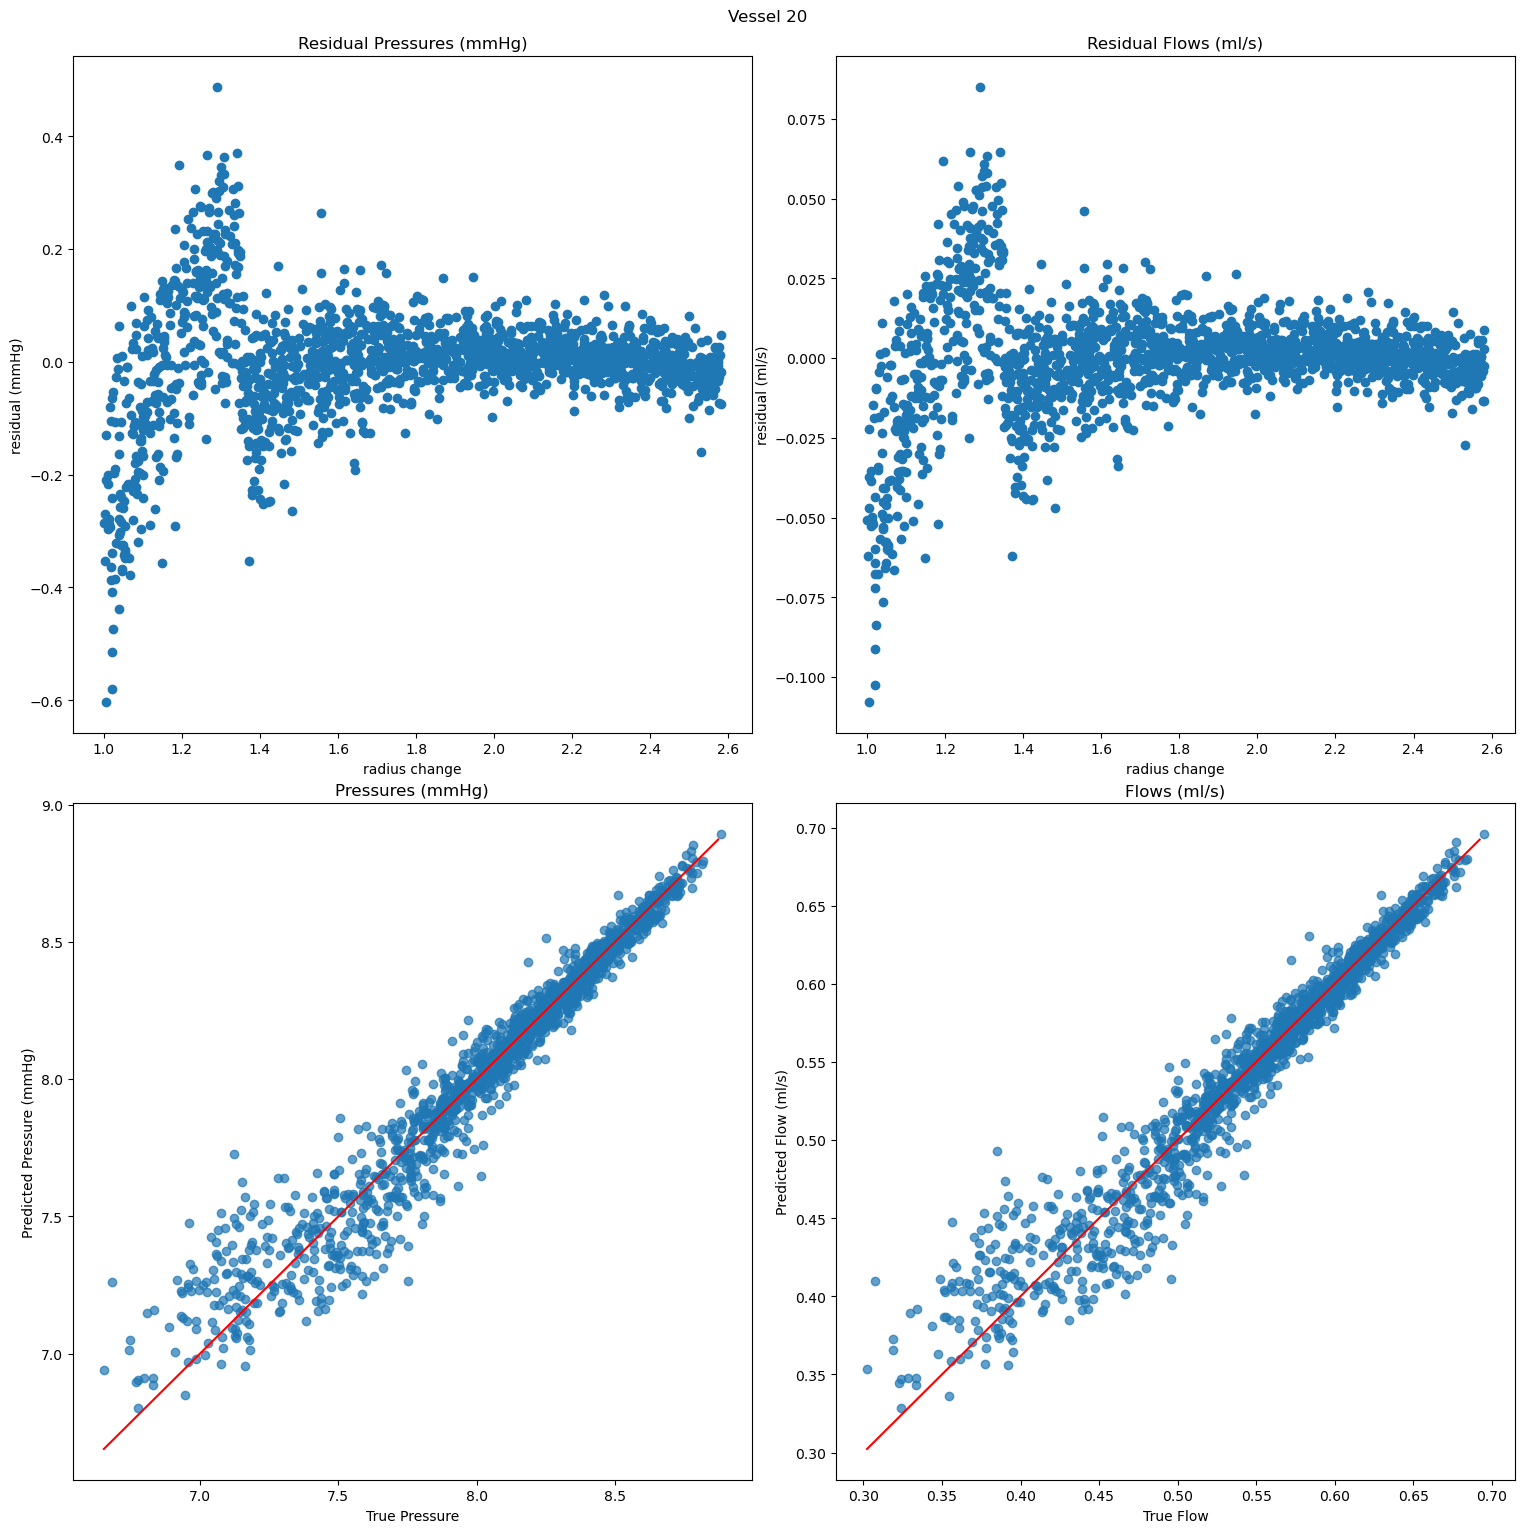

In [102]:
plot_animation(predict_input(3), predict_output(3), save = '../pptx/pptx_img/model.filter.gif')

In [22]:
model_metrics(predict_input(3), predict_output(3))

13.52% | 16.72% | 19.29% | 17.08% | 15.97% | 15.11% | 16.31% | 19.54% | 8.97% | 24.12% | 31.41% | 24.1% | 14.44% | 22.6% | 28.42% | 20.11% | 18.83% | 9.59% | 27.08% | 8.06% | 18.13% | 
Average Pressure RAE: 18.54%
10.43% | 16.68% | 18.34% | 11.73% | 15.98% | 15.12% | 16.28% | 19.57% | 9.01% | 24.17% | 31.42% | 24.14% | 14.46% | 22.63% | 28.46% | 20.12% | 18.86% | 9.58% | 27.11% | 8.09% | 18.13% | 
Average Flow RAE: 18.11%
Average Total RAE: 18.33%
Max Relative Error: 55.995%
Avg Relative Error: 1.798%


Although we filter out/split 1.35, the layers after the filter are still fully connected so it is causing mixing.

# Version 4

Just sparsify input to 2n and filter from there

Final Train Loss: 0.0004560654051601
Final Val Loss: 0.0007891497807577
Final Test Loss: 0.0007799405138939


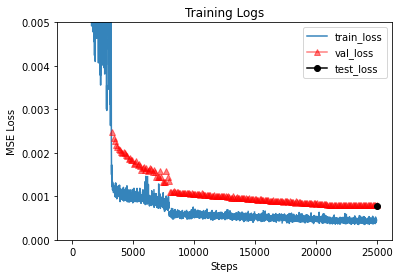

In [23]:
plot_losses(pd.read_csv(dataframe(4)), .005)

In [103]:
interact(plot_residuals, predict_input = fixed(predict_input(4)), predict_output = fixed(predict_output(4)), vessel = (0, len(predict_input(4)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [104]:
interact(plot_yhat, predict_input = fixed(predict_input(4)), predict_output = fixed(predict_output(4)), vessel = (0, len(predict_input(4)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [26]:
model_metrics(predict_input(4), predict_output(4))

2.86% | 3.09% | 3.91% | 2.94% | 2.96% | 3.15% | 2.77% | 3.52% | 2.7% | 3.5% | 3.68% | 3.31% | 3.17% | 3.75% | 3.68% | 3.29% | 3.5% | 3.13% | 4.24% | 2.01% | 3.34% | 
Average Pressure RAE: 3.26%
2.57% | 3.08% | 3.71% | 2.8% | 2.96% | 3.16% | 2.75% | 3.52% | 2.7% | 3.5% | 3.68% | 3.31% | 3.19% | 3.74% | 3.7% | 3.29% | 3.47% | 3.13% | 4.23% | 2.02% | 3.35% | 
Average Flow RAE: 3.23%
Average Total RAE: 3.25%
Max Relative Error: 14.991%
Avg Relative Error: 0.331%


# Version 5

minimum of data shifted to .95

Final Train Loss: 0.0003357602108735
Final Val Loss: 0.0004620014515239
Final Test Loss: 0.0004970407462678


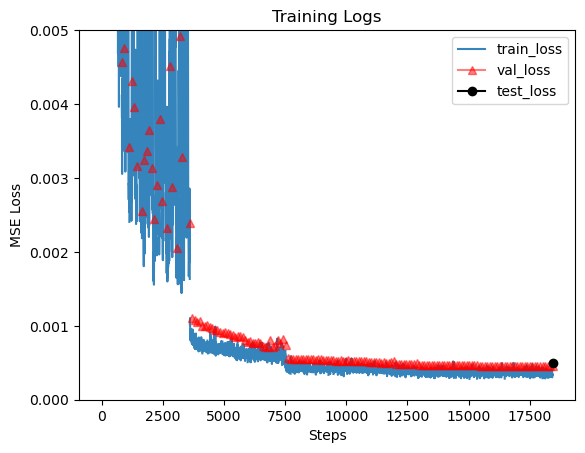

In [107]:
plot_losses(pd.read_csv(dataframe(5)), .005)



In [108]:
interact(plot_residuals, predict_input = fixed(predict_input(5)), predict_output = fixed(predict_output(5)), vessel = (0, len(predict_input(5)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [109]:
interact(plot_yhat, predict_input = fixed(predict_input(5)), predict_output = fixed(predict_output(5)), vessel = (0, len(predict_input(5)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

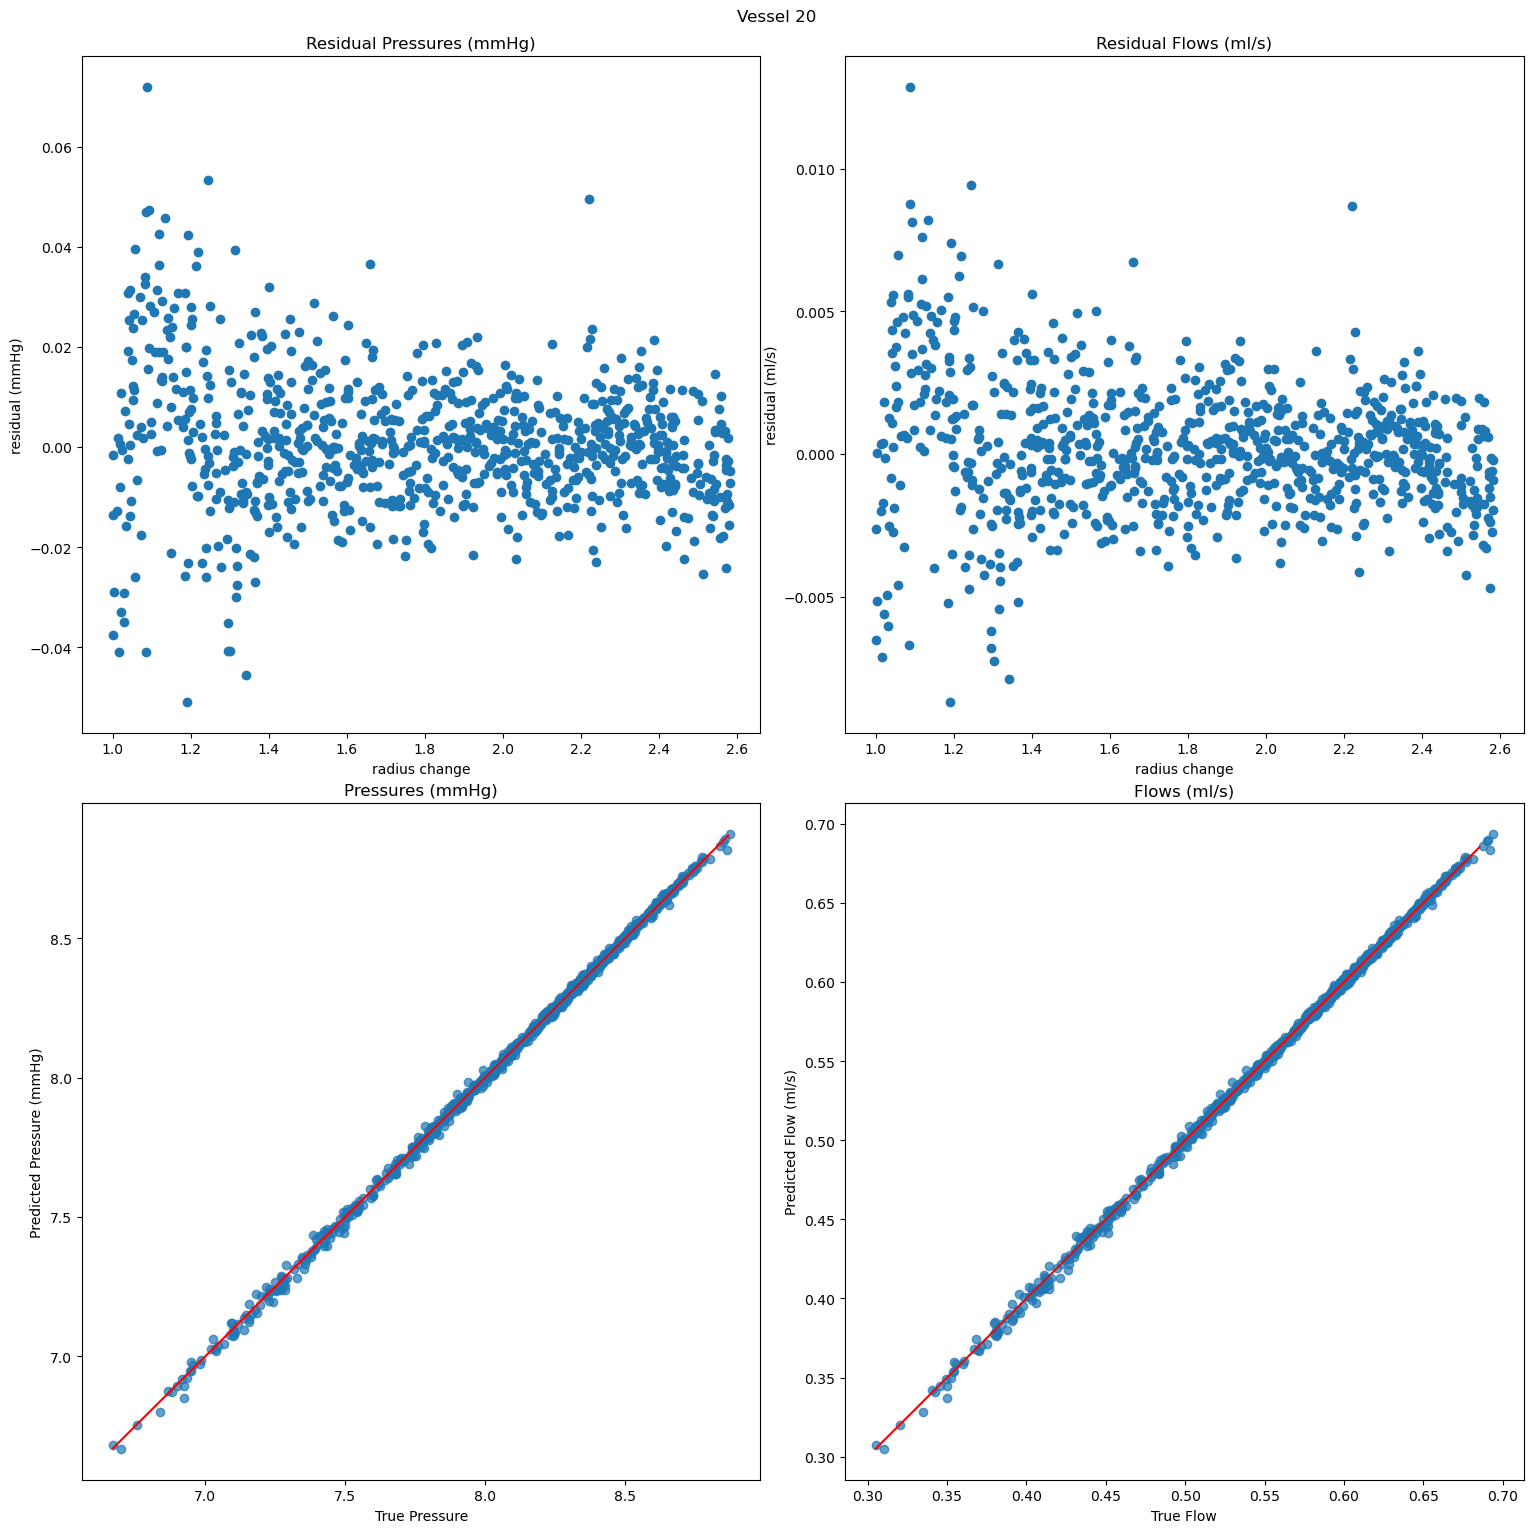

In [111]:
plot_animation(predict_input(5), predict_output(5), save = '../pptx/pptx_img/model.shift.gif')

In [110]:
model_metrics(predict_input(5), predict_output(5))

2.16% | 2.44% | 2.46% | 2.28% | 2.31% | 2.26% | 2.06% | 2.43% | 2.21% | 2.67% | 2.52% | 2.52% | 2.67% | 2.98% | 2.6% | 2.55% | 2.47% | 2.49% | 2.85% | 1.67% | 2.75% | 
Average Pressure RAE: 2.45%
1.9% | 2.43% | 2.44% | 2.08% | 2.3% | 2.29% | 2.07% | 2.44% | 2.22% | 2.66% | 2.5% | 2.51% | 2.64% | 3.0% | 2.6% | 2.54% | 2.47% | 2.48% | 2.87% | 1.72% | 2.76% | 
Average Flow RAE: 2.42%
Average Total RAE: 2.43%
Max Relative Error: 7.354%
Avg Relative Error: 0.246%


Version 7
    - Identical, but validation loss has been changed to also not include < 0 samples

Final Train Loss: 0.0005830129957757
Final Val Loss: 0.0004482982039917
Final Test Loss: 0.0007056404137983


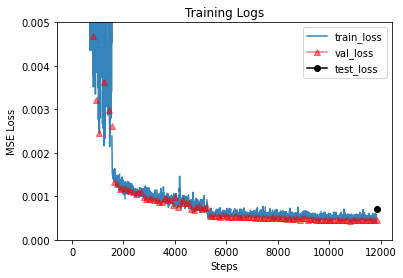

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

2.58% | 2.76% | 3.05% | 2.86% | 3.04% | 2.83% | 2.25% | 3.06% | 2.61% | 3.58% | 3.52% | 2.87% | 2.84% | 3.79% | 3.42% | 3.55% | 3.09% | 3.1% | 3.49% | 2.06% | 2.96% | 
Average Pressure RAE: 3.02%
2.31% | 2.77% | 3.01% | 2.63% | 3.0% | 2.78% | 2.26% | 3.12% | 2.61% | 3.58% | 3.48% | 2.84% | 2.88% | 3.7% | 3.44% | 3.56% | 3.08% | 3.14% | 3.45% | 2.09% | 2.96% | 
Average Flow RAE: 2.99%
Average Total RAE: 3.0%
Max Relative Error: 7.724%
Avg Relative Error: 0.301%


In [31]:
plot_losses(pd.read_csv(dataframe(7)), .005)
interact(plot_residuals, predict_input = fixed(predict_input(7)), predict_output = fixed(predict_output(7)), vessel = (0, len(predict_input(7)[0]) - 1))
interact(plot_yhat, predict_input = fixed(predict_input(7)), predict_output = fixed(predict_output(7)), vessel = (0, len(predict_input(7)[0]) - 1))
model_metrics(predict_input(7), predict_output(7))

# Version 6

In [32]:
# moves minimum to .75

Final Train Loss: 0.0006572208949364
Final Val Loss: 0.0008572058868594
Final Test Loss: 0.0008667914080433


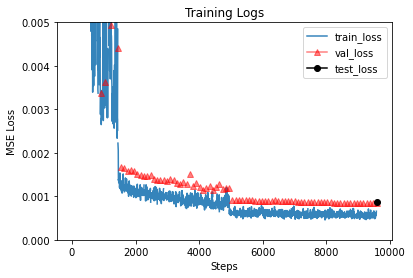

In [33]:
plot_losses(pd.read_csv(dataframe(6)), .005)


In [34]:
interact(plot_residuals, predict_input = fixed(predict_input(6)), predict_output = fixed(predict_output(6)), vessel = (0, len(predict_input(6)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [35]:
interact(plot_yhat, predict_input = fixed(predict_input(6)), predict_output = fixed(predict_output(6)), vessel = (0, len(predict_input(6)[0]) - 1))


interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [36]:
model_metrics(predict_input(6), predict_output(6))

3.42% | 4.06% | 4.12% | 3.71% | 4.07% | 4.12% | 3.01% | 3.84% | 3.21% | 5.49% | 4.64% | 3.95% | 3.88% | 4.69% | 4.59% | 4.01% | 3.74% | 4.56% | 5.25% | 2.27% | 4.56% | 
Average Pressure RAE: 4.06%
3.09% | 4.12% | 4.14% | 3.16% | 4.13% | 4.28% | 3.11% | 3.99% | 3.23% | 5.71% | 4.63% | 4.05% | 3.83% | 4.78% | 4.71% | 4.14% | 3.67% | 4.52% | 5.13% | 2.36% | 4.64% | 
Average Flow RAE: 4.07%
Average Total RAE: 4.06%
Max Relative Error: 4.951%
Avg Relative Error: 0.395%


# Version 8

- Changed min to .95, validation and test still keeps 1
- ~ 50% less data in desired space since (1.6/1.65)^21 = 52%.
- Split train, test, validation data generation using different sobol seeds. (16k, 4k, 4k)

Final Train Loss: 0.0003870772197842
Final Val Loss: 0.0003193026350345
Final Test Loss: 0.0003171009884681


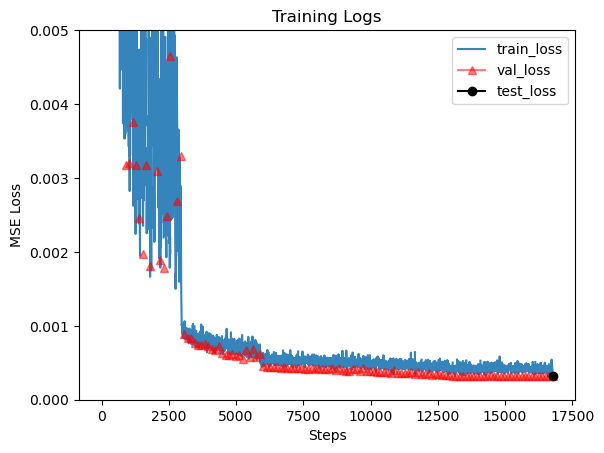

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

2.32% | 2.43% | 2.75% | 2.36% | 2.31% | 2.47% | 2.42% | 2.65% | 2.25% | 2.83% | 2.76% | 2.55% | 2.46% | 3.03% | 2.94% | 2.94% | 2.67% | 2.34% | 3.13% | 1.78% | 2.72% | 
Average Pressure RAE: 2.58%
2.01% | 2.44% | 2.7% | 2.18% | 2.32% | 2.49% | 2.42% | 2.66% | 2.25% | 2.84% | 2.75% | 2.54% | 2.47% | 3.03% | 2.92% | 2.95% | 2.65% | 2.35% | 3.13% | 1.79% | 2.73% | 
Average Flow RAE: 2.55%
Average Total RAE: 2.57%
Max Relative Error: 11.19%
Avg Relative Error: 0.256%


In [106]:
plot_losses(pd.read_csv(dataframe(8)), .005)
interact(plot_residuals, predict_input = fixed(predict_input(8)), predict_output = fixed(predict_output(8)), vessel = (0, len(predict_input(8)[0]) - 1))
interact(plot_yhat, predict_input = fixed(predict_input(8)), predict_output = fixed(predict_output(8)), vessel = (0, len(predict_input(8)[0]) - 1))
model_metrics(predict_input(8), predict_output(8))

# Version 9
- uses sigmoid instead of relu

Final Train Loss: 0.0001452119468012
Final Val Loss: 0.0001452003343729
Final Test Loss: 0.0001443921210011


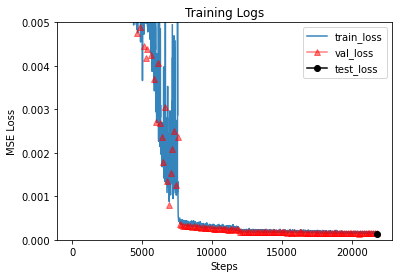

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

1.27% | 1.71% | 1.98% | 1.74% | 1.63% | 1.62% | 1.42% | 1.93% | 1.53% | 1.82% | 1.97% | 1.73% | 1.5% | 1.94% | 2.0% | 1.87% | 1.79% | 1.61% | 2.41% | 1.15% | 1.82% | 
Average Pressure RAE: 1.73%
1.08% | 1.69% | 1.96% | 1.36% | 1.62% | 1.61% | 1.42% | 1.93% | 1.52% | 1.82% | 1.98% | 1.73% | 1.53% | 1.94% | 2.02% | 1.85% | 1.79% | 1.63% | 2.42% | 1.13% | 1.83% | 
Average Flow RAE: 1.71%
Average Total RAE: 1.72%
Max Relative Error: 5.255%
Avg Relative Error: 0.171%


In [38]:
plot_losses(pd.read_csv(dataframe(9)), .005)
interact(plot_residuals, predict_input = fixed(predict_input(9)), predict_output = fixed(predict_output(9)), vessel = (0, len(predict_input(9)[0]) - 1))
interact(plot_yhat, predict_input = fixed(predict_input(9)), predict_output = fixed(predict_output(9)), vessel = (0, len(predict_input(9)[0]) - 1))
model_metrics(predict_input(9), predict_output(9))

# Version 10
- Tanh

Final Train Loss: 6.803386349929497e-05
Final Val Loss: 7.49734608689323e-05
Final Test Loss: 7.259479025378823e-05


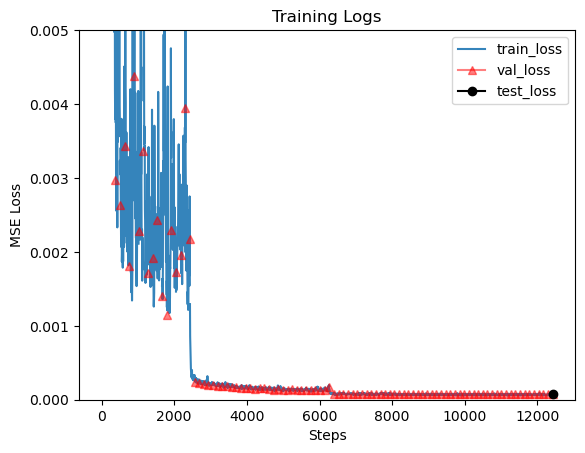

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

1.18% | 1.15% | 1.33% | 1.16% | 1.15% | 1.26% | 1.04% | 1.32% | 1.05% | 1.29% | 1.3% | 1.34% | 1.2% | 1.34% | 1.28% | 1.26% | 1.23% | 1.23% | 1.44% | 0.94% | 1.24% | 
Average Pressure RAE: 1.22%
1.08% | 1.15% | 1.29% | 1.08% | 1.15% | 1.24% | 1.07% | 1.33% | 1.04% | 1.3% | 1.3% | 1.34% | 1.19% | 1.36% | 1.29% | 1.25% | 1.23% | 1.24% | 1.42% | 0.93% | 1.25% | 
Average Flow RAE: 1.22%
Average Total RAE: 1.22%
Max Relative Error: 4.268%
Avg Relative Error: 0.123%


In [112]:
v = 10
plot_losses(pd.read_csv(dataframe(v)), .005)
interact(plot_residuals, predict_input = fixed(predict_input(v)), predict_output = fixed(predict_output(v)), vessel = (0, len(predict_input(v)[0]) - 1))
interact(plot_yhat, predict_input = fixed(predict_input(v)), predict_output = fixed(predict_output(v)), vessel = (0, len(predict_input(v)[0]) - 1))
model_metrics(predict_input(v), predict_output(v))

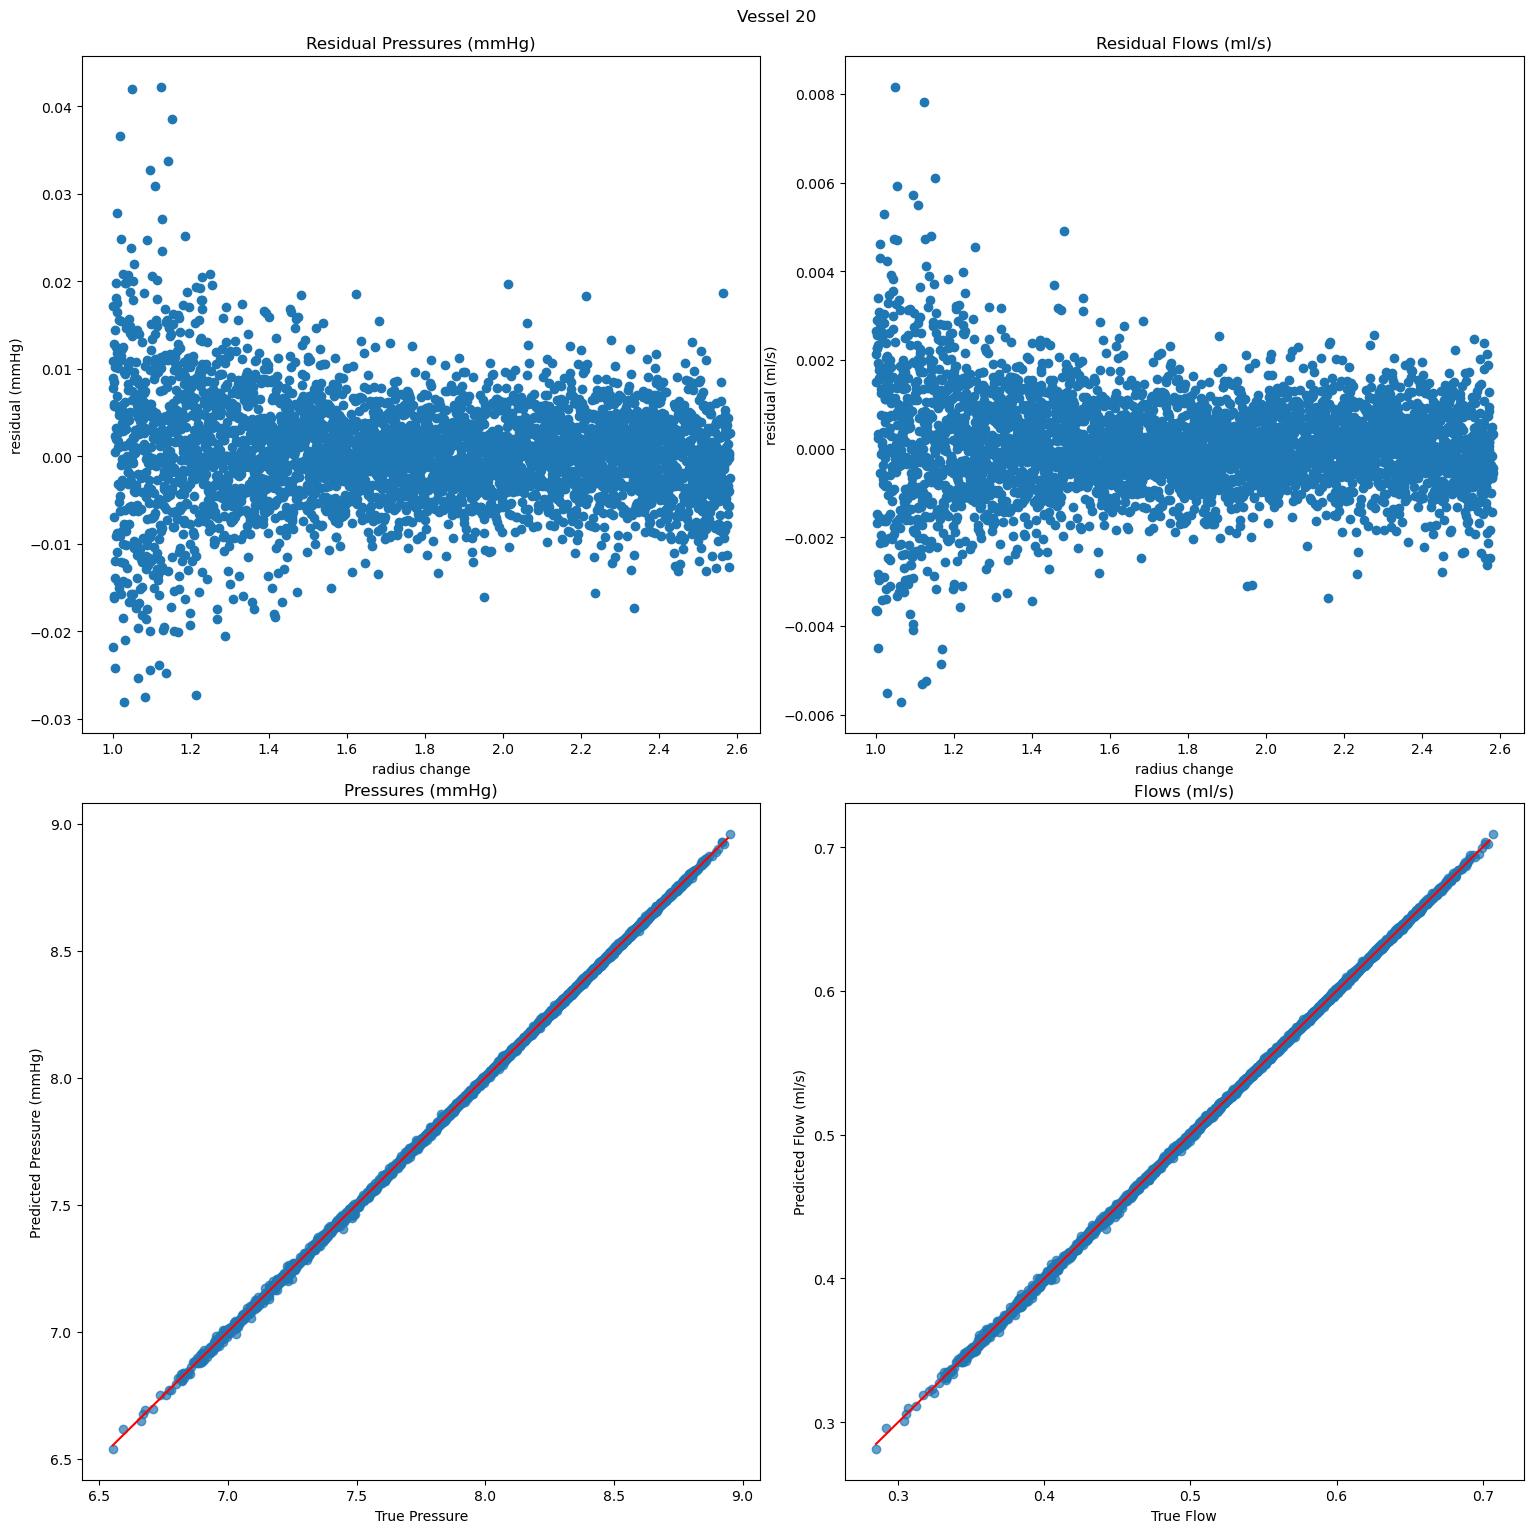

In [114]:
plot_animation(predict_input(10), predict_output(10), save = '../pptx/pptx_img/model.tanh.gif')

# Version 11
- 2x data (corresponds with same space as previous runs without .95 start)

In [24]:
v = 11
#plot_losses(pd.read_csv(dataframe(v)), .0005)
interact(plot_residuals, predict_input = fixed(predict_input(v)), predict_output = fixed(predict_output(v)), vessel = (0, len(predict_input(v)[0]) - 1))
interact(plot_yhat, predict_input = fixed(predict_input(v)), predict_output = fixed(predict_output(v)), vessel = (0, len(predict_input(v)[0]) - 1))
model_metrics(predict_input(v), predict_output(v))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

0.64% | 0.61% | 0.72% | 0.59% | 0.64% | 0.68% | 0.6% | 0.74% | 0.61% | 0.7% | 0.74% | 0.7% | 0.67% | 0.77% | 0.75% | 0.72% | 0.66% | 0.68% | 0.79% | 0.51% | 0.7% | 
Average Pressure RAE: 0.68%
0.59% | 0.62% | 0.7% | 0.58% | 0.65% | 0.68% | 0.59% | 0.74% | 0.61% | 0.71% | 0.75% | 0.72% | 0.68% | 0.76% | 0.75% | 0.71% | 0.67% | 0.68% | 0.79% | 0.51% | 0.7% | 
Average Flow RAE: 0.68%
Average Total RAE: 0.68%
Max Relative Error: 2.334%
Avg Relative Error: 0.068%


In [17]:
import numpy as np
from matplotlib.animation import FuncAnimation


In [ ]:
def plot_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(2, 2, figsize = (16, 16))
    fig.tight_layout(pad = 3,rect = (.02,.02,1, .98))
    ax = ax.flatten()
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
        
        ax[2].clear()
        ax[3].clear()
        ax[2].set_title('Pressures (mmHg)')
        ax[2].set_xlabel('True Pressure')
        ax[2].set_ylabel('Predicted Pressure (mmHg)')
        ax[3].set_title('Flows (ml/s)')
        ax[3].set_xlabel('True Flow')
        ax[3].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[2].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        t = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[2].plot(t, t, color = 'r')
        ax[3].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        t = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[3].plot(t, t, color = 'r')
        
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_residuals_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_yhat_animation(predict_input, predict_output, save):
    
    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Pressures (mmHg)')
        ax[0].set_xlabel('True Pressure')
        ax[0].set_ylabel('Predicted Pressure (mmHg)')
        ax[1].set_title('Flows (ml/s)')
        ax[1].set_xlabel('True Flow')
        ax[1].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[0].plot(x, x, color = 'r')
        ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[1].plot(x, x, color = 'r')
        fig.suptitle(f'Vessel {vessel}')
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)

In [89]:
def plot_residuals_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_yhat_animation(predict_input, predict_output, save):
    
    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Pressures (mmHg)')
        ax[0].set_xlabel('True Pressure')
        ax[0].set_ylabel('Predicted Pressure (mmHg)')
        ax[1].set_title('Flows (ml/s)')
        ax[1].set_xlabel('True Flow')
        ax[1].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[0].plot(x, x, color = 'r')
        ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[1].plot(x, x, color = 'r')
        fig.suptitle(f'Vessel {vessel}')
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)

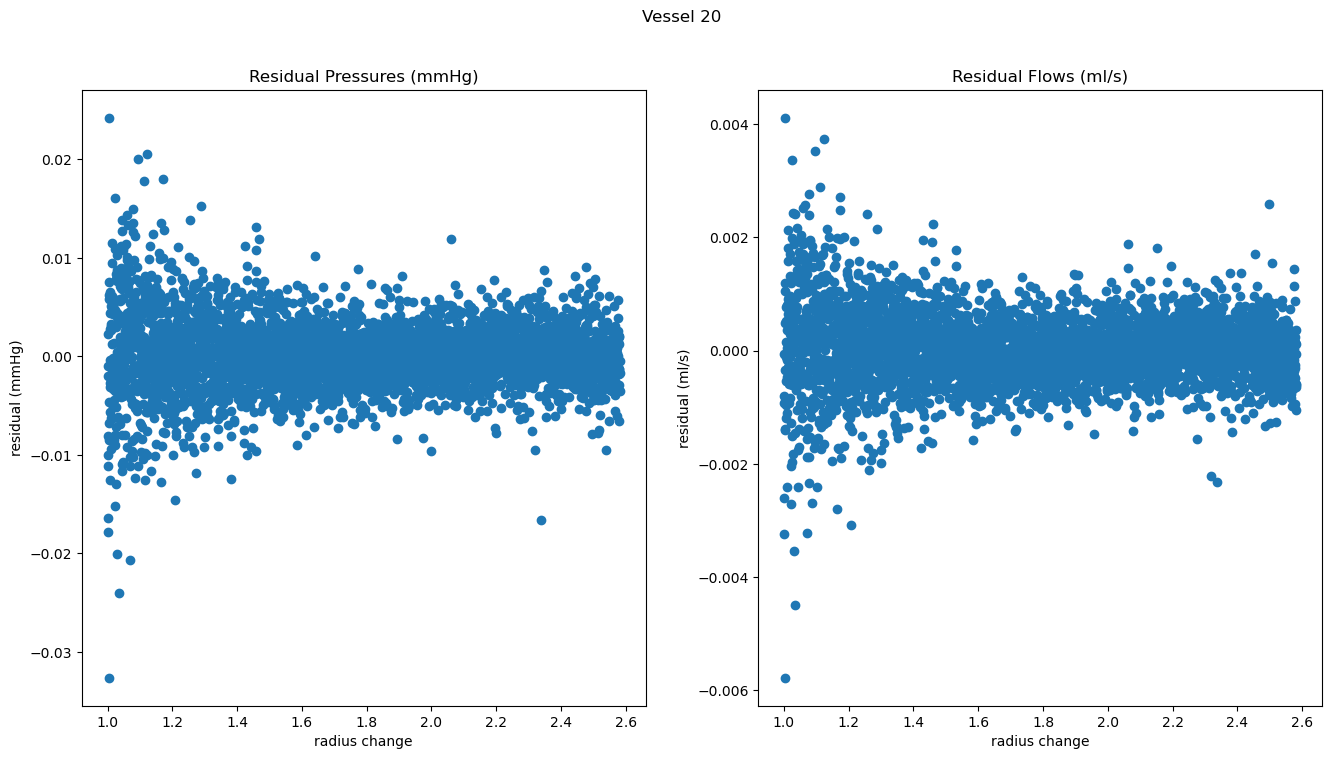

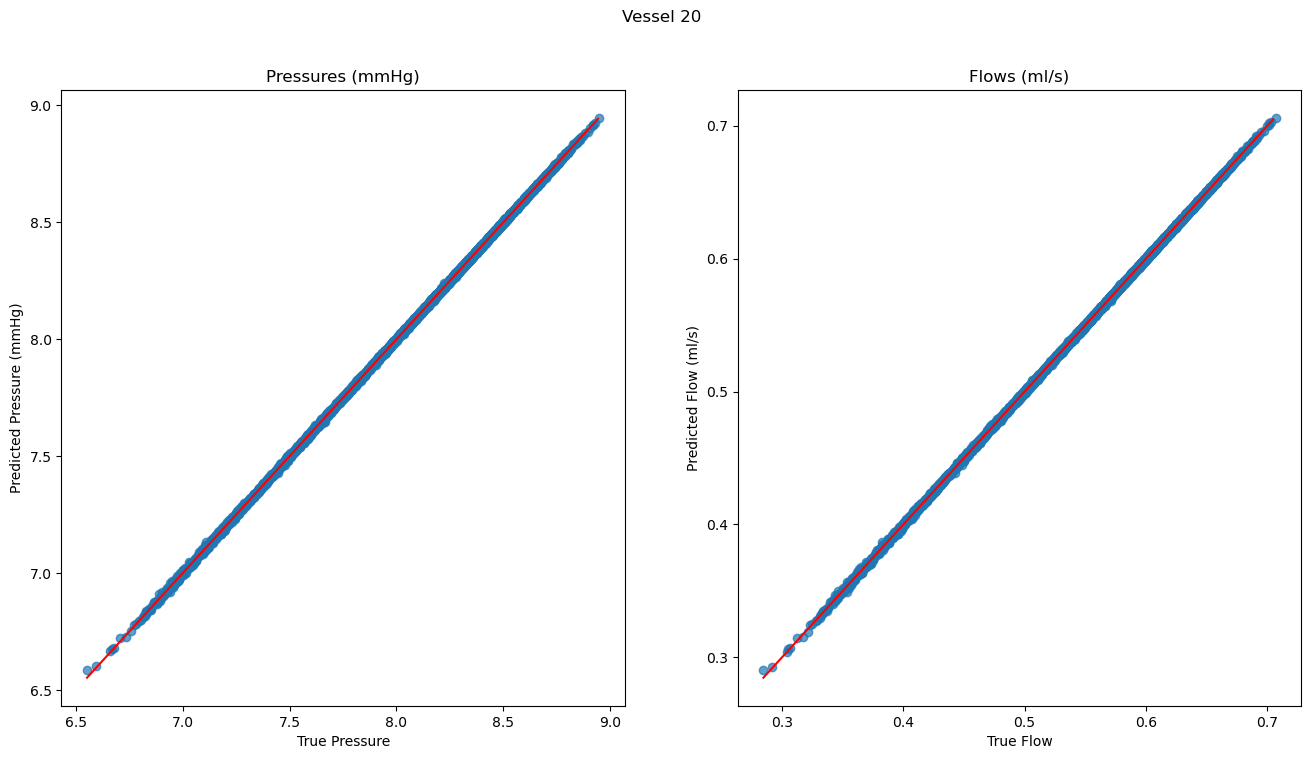

In [90]:
plot_residuals_animation(predict_input(11), predict_output(11), save = '../pptx/pptx_img/model_residuals.best.gif')
plot_yhat_animation(predict_input(11), predict_output(11), save = '../pptx/pptx_img/model_yhat.best.gif')

In [7]:
x, y, yhat = get_y(predict_input(11), predict_output(11))
residuals = y - yhat

In [11]:
import numpy as np

array([[2.5369985, 2.1315951, 1.2819347, ..., 1.8577397, 2.2355514,
        2.5064137],
       [1.6441199, 1.3207992, 1.9748336, ..., 1.2273545, 1.5398599,
        1.3185898],
       [1.3481011, 2.494507 , 1.4514234, ..., 1.4936007, 2.02648  ,
        2.0076942],
       ...,
       [1.3478373, 1.0597708, 1.3469418, ..., 1.935581 , 1.3204205,
        1.9702591],
       [1.6436145, 2.2580028, 2.4620562, ..., 2.5591977, 2.202689 ,
        1.084133 ],
       [2.5365381, 1.4906588, 1.5729647, ..., 1.5084841, 1.5079567,
        2.272002 ]], dtype=float32)

In [14]:
data = {'x': x.numpy(), 'y': y.numpy(), 'yhat': yhat.numpy()}

In [15]:
np.save('../images/best_model_data.npy', data, allow_pickle=True)